In [1]:
#### 

# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

from sklearn.impute import KNNImputer ####IMPORTANTE ESTA LIBRERIA IMPUTACION MISSINGS


In [2]:
# Descarga fichero
# Descarga fichero
path_dataset = 'C:\\Users\\Usuario\\Desktop\\bigdata\\bigarrenurtea\\reto6\\datos_transformados\\'# ruta donde se encuentran los datos

# importar los csv

usuarios = pd.read_csv(path_dataset + 'usuarios.csv')
tutores_perfil = pd.read_csv(path_dataset + 'tutores_perfil.csv')
conocimientos = pd.read_csv(path_dataset + 'conocimientos.csv')
cursos = pd.read_csv(path_dataset + 'cursos.csv')
programas = pd.read_csv(path_dataset + 'programas.csv')
cursos_en_programas = pd.read_csv(path_dataset + 'cursos_en_programas.csv')
itinerarios = pd.read_csv(path_dataset + 'itinerarios.csv')
notas_cursos = pd.read_csv(path_dataset + 'notas_cursos.csv')
roles = pd.read_csv(path_dataset + 'roles.csv')
plantas = pd.read_csv(path_dataset + 'plantas.csv')
accesos = pd.read_csv(path_dataset + 'accesos.csv')
actividades = pd.read_csv(path_dataset + 'actividades.csv')

# Variables Clustering

In [3]:
#Seleccionar user_id y mdl_user_id
usuarios_clustering = usuarios.loc[:, ['user_id','mdl_user_id']]

#Numero de cursos realizados por usuario
num_cursos = notas_cursos.groupby('user_id').agg(num_cursos=('course_name','count')).reset_index()

#Nota media por usuario en los cursos realizados
nota_media_cursos = notas_cursos.groupby('user_id').agg(nota_media_curso=('grade','mean')).reset_index()

#Numero de actividades realizados por usuario
num_actividades = actividades.groupby('mdl_user_id').agg(num_actividades=('actividad_name','count')).reset_index()

#Nota media por usuario en las actividades realizadas
nota_media_actividades = actividades.groupby('mdl_user_id').agg(nota_media_actividades=('grade','mean')).reset_index()

#Numero de programas realizados por usuario
num_programas = itinerarios.groupby('user_id').agg(num_programas=('program_name','count')).reset_index()

#Media de frecuencia de acceso al mes por usuario
pre_num_accesos = accesos["timestamp"].str.split(expand=True)##Separar timestamp para obtener frecuencia de acceso mensual
pre_num_accesos.columns = ['fecha', 'tiempo']#renombrar columnas

pre_num_accesos =  pre_num_accesos["fecha"].str.split('-',expand=True)#separar la fecha en año-mes-dia
pre_num_accesos.columns = ['año', 'mes', 'dia']#renombrar las columnas

num_accesos = pd.concat([accesos, pre_num_accesos], axis=1)#juntar tablas
num_accesos.loc[:, ['mdl_user_id','user_id','año','mes','dia']]#seleccionar las columnas necesarias para el clustering

frecuencia_acceso_mensual = num_accesos.groupby(['user_id','mes']).agg(frecuencia_acceso_mensual=('dia','count')).reset_index()

frecuencia_media_acceso_mensual= frecuencia_acceso_mensual.groupby('user_id').agg(frecuencia_media_acceso_mensual=('frecuencia_acceso_mensual','mean')).reset_index()

#### Preparacion tabla para clusterizacion

In [4]:
#Se inserta la nota media de los cursos a la tabla de usuarios que contiene el idioma , mdl_user_id y user_id

usuarios_clustering = usuarios_clustering.merge(nota_media_cursos, on="user_id", how = "right") 
usuarios_clustering = usuarios_clustering.dropna()#las 3 instancias que no tienen un idiomas asociado ni un usuario de mudle fuera(si no tiene usuario de mudle no ha podido realizar cursos)

In [5]:
#A la tabla anterior se le añade la informacion de la cantidad de cursos realizados

usuarios_clustering = usuarios_clustering.merge(num_cursos, on="user_id", how = "left") 

In [6]:
#A la tabla anterior se le añade la informacion de la cantidad de actividades realizadas

usuarios_clustering = usuarios_clustering.merge(num_actividades, on="mdl_user_id", how = "right") 
usuarios_clustering = usuarios_clustering.dropna()#existe un porcentaje pequeño de usuarios que no han realizado actividades. Por lo tanto, como no aporta valor a laclusterizacion se eliminan(hay q tener en cuenta que la base de datos original dispone de muy pocos datos y ademas datos bastante pobres)

In [7]:
#A la tabla anterior se le añade la informacion de la nota media de las actividades realizadas

usuarios_clustering = usuarios_clustering.merge(nota_media_actividades, on="mdl_user_id", how = "left")
usuarios_clustering.isnull().sum() * 100 / len(usuarios_clustering)#existe un porcentaje muy muy pequeño(3%) de usuarios que no tienen nota media.

#Se utiliza knn para imputar dichos valores, puesto que no se ve oportuno eliminarlos directamente
#from sklearn.impute import KNNImputer ------ IMPORTANTE ESTA LIBRERIA IMPUTACION MISSINGS

# Construimos el modelo
imputer = KNNImputer(n_neighbors=5, weights="uniform")

# Ajustamos el modelo e imputamos los missing values
imputer.fit(usuarios_clustering[["nota_media_actividades"]])
usuarios_clustering["nota_media_actividades"] = imputer.transform(usuarios_clustering[["nota_media_actividades"]]).ravel()

In [8]:
#A la tabla anterior se le añade la informacion de la cantidad de programas realizadas

usuarios_clustering = usuarios_clustering.merge(num_programas, on="user_id", how = "left") #planta_name(key value) para introducir columna planta_id

In [9]:
#A la tabla anterior se le añade la informacion de la frecuencia media de acceso mensual por usuario

usuarios_clustering = usuarios_clustering.merge(frecuencia_media_acceso_mensual, on="user_id", how = "left") 
usuarios_clustering.isnull().sum() * 100 / len(usuarios_clustering)#se observa que el 10%de los usuarios no tienen apuntado la frecuencia de acceso. 
#Por tanto, se les asignara un valor utilizando la funcion knn (identificar los registros más similares al que presenta los valores nulos y asignarle la media de sus vecinos)

# Ajustamos el modelo previamente creado e imputamos los missing values
imputer.fit(usuarios_clustering[["frecuencia_media_acceso_mensual"]])
usuarios_clustering["frecuencia_media_acceso_mensual"] = imputer.transform(usuarios_clustering[["frecuencia_media_acceso_mensual"]]).ravel()

In [10]:
#Observar que todos los valores estan correctos para comenzar con el proceso de la clusterizacion
usuarios_clustering[usuarios_clustering.isnull().any(1)]#se observa q todo se encuentra como debe sin ningun missing

,user_id,mdl_user_id,nota_media_curso,num_cursos,num_actividades,nota_media_actividades,num_programas,frecuencia_media_acceso_mensual


In [11]:
usuarios_clustering.head()#se muestra la tabla definitiva para el proceso de clusterizacion

,user_id,mdl_user_id,nota_media_curso,num_cursos,num_actividades,nota_media_actividades,num_programas,frecuencia_media_acceso_mensual
0,3.0,13.0,0.666667,15.0,3,10.000000,3,1.000000
1,4.0,14.0,4.091000,10.0,46,7.882088,3,3.435001
2,5.0,15.0,2.222222,9.0,44,8.575606,2,3.435001
3,7.0,18.0,3.858000,5.0,44,8.031091,1,3.435001
4,8.0,19.0,2.914000,5.0,39,8.286821,1,3.435001


# CLUSTERING

#### IMPORTANDO LIBRERIAS


In [12]:
#Importing the Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import datetime
import matplotlib
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)
from sklearn import preprocessing 

#### DATA CLEANING

In [13]:
user_mdl_id=usuarios_clustering[['user_id','mdl_user_id']]#guardar en otra variable los datos de user_id y mdl_user_id
usuarios_clustering = usuarios_clustering.drop(['user_id','mdl_user_id'], axis=1)#df para utilizar en el clustering


In [14]:
usuarios_clustering.describe()#se observa rapidamente la estadisticas principales del dataset
#Las estadisticas anteriores muestran algunas discrepancias en las variables puesto que el maximo se desvia mucho de la media.

,nota_media_curso,num_cursos,num_actividades,nota_media_actividades,num_programas,frecuencia_media_acceso_mensual
count,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000
mean,4.112720,14.895954,16.364162,8.763272,1.641618,3.435001
std,2.996642,17.025994,9.981977,1.500478,2.832310,3.961339
min,0.000000,1.000000,2.000000,1.660000,1.000000,1.000000
25%,2.527111,6.000000,10.000000,8.542500,1.000000,1.500000
50%,3.097222,12.000000,15.000000,9.214000,1.000000,2.000000
75%,5.272222,18.000000,21.000000,9.682000,1.000000,3.435001
max,9.976667,191.000000,59.000000,10.000000,35.000000,39.636364


Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 432x288 with 0 Axes>

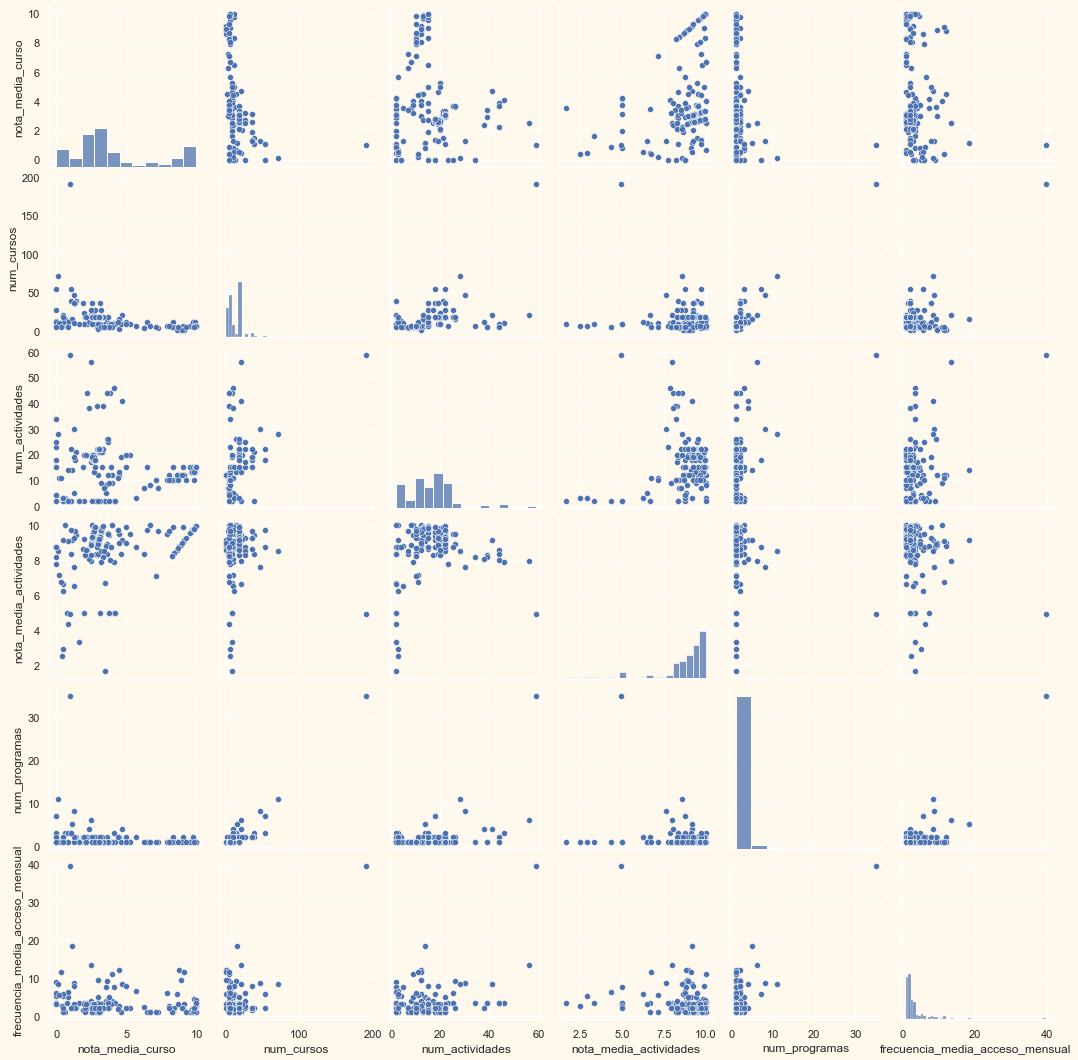

In [15]:
#Para ello, hay que echar un vistazo a la vision más amplia de los datos.Se trazan algunas de las características seleccionadas.

#Para trazar algunas características seleccionadas
#Seleccionando colores
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

#Trazar las siguientes características
To_Plot = [ "nota_media_curso", "num_cursos", "num_actividades", "nota_media_actividades", "num_programas", "frecuencia_media_acceso_mensual"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(usuarios_clustering[To_Plot],palette= (["#682F2F","#F3AB60"]))
plt.show()

In [16]:
#Dropping the outliers by setting a cap on Age and income. 
usuarios_clustering = usuarios_clustering[(usuarios_clustering["num_actividades"]<55)]
usuarios_clustering = usuarios_clustering[(usuarios_clustering["num_programas"]<25)]
print("The total number of data-points after removing the outliers are:", len(usuarios_clustering))

The total number of data-points after removing the outliers are: 171


<AxesSubplot:>

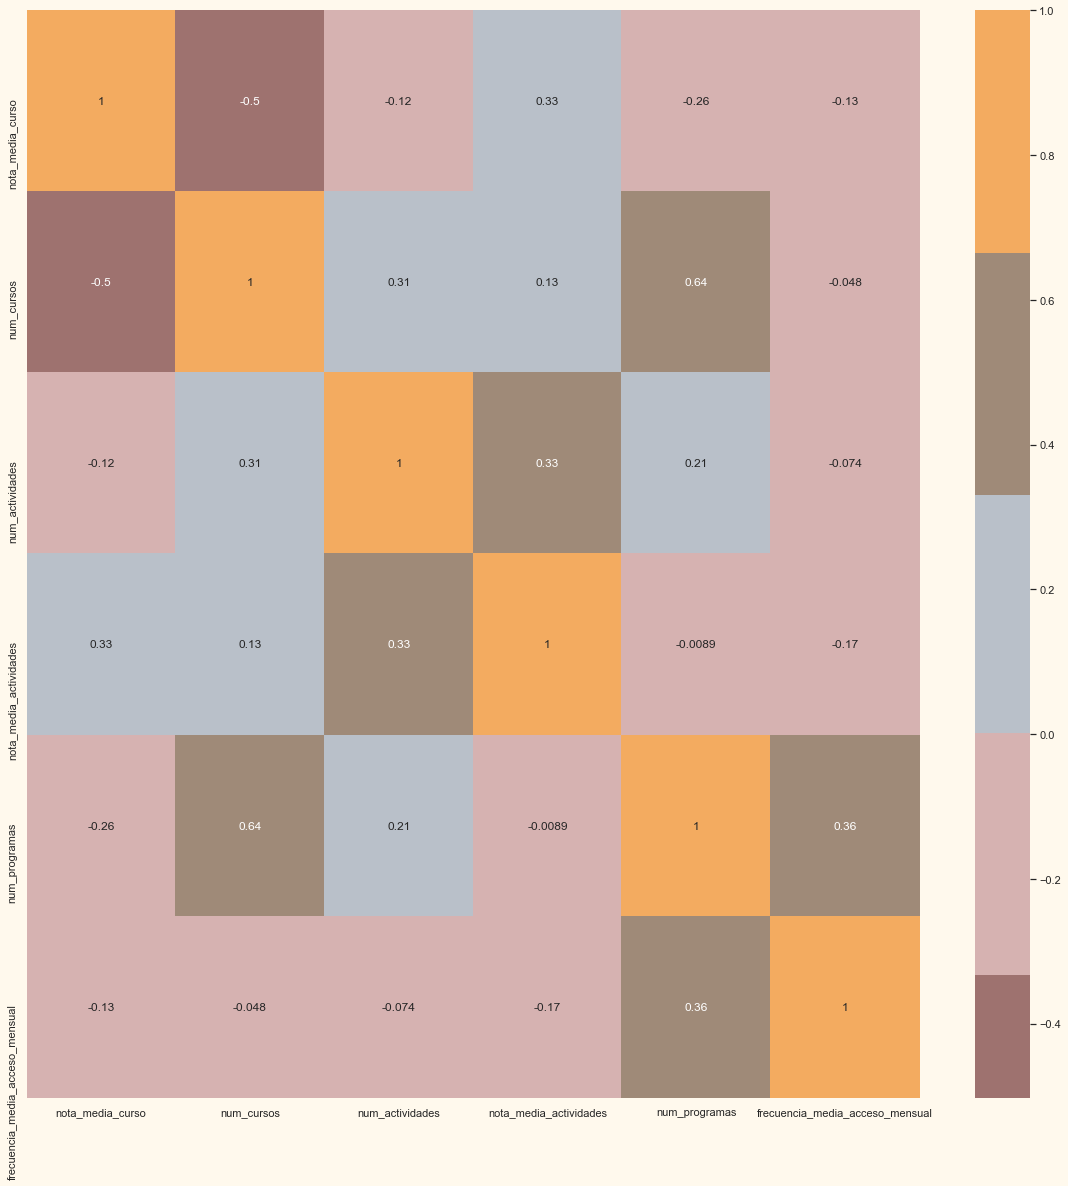

In [17]:
#Matriz de correlacion
corrmat= usuarios_clustering.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

#### PREPOCESAMIENTO DE DATOS

In [18]:
# PASO1- Escalado de las características utilizando el escalador estándar

#Creando una copia del dataframe
df_copy = usuarios_clustering.copy()

#Escalar los datos
sc = StandardScaler()
xx_scaled = sc.fit_transform(df_copy)
scaled_df_copy = pd.DataFrame(xx_scaled)
print("Todas las columnas estan ahora escaladas")

Todas las columnas estan ahora escaladas


In [19]:
# PASO2- Creación de un marco de datos subconjunto para la reducción de dimensionalidad

# Se usaran los datos escalados para reducir la dimensionalidad
print("Marco de datos que se utilizará para la modelización posterior:")
scaled_df_copy.head()

Marco de datos que se utilizará para la modelización posterior:


,0,1,2,3,4,5
0,-1.160561,0.112095,-1.438809,0.820336,1.333663,-0.793064
1,-0.016522,-0.367112,3.363534,-0.616023,1.333663,0.099308
2,-0.640864,-0.462954,3.140169,-0.145682,0.489010,0.099308
3,-0.094365,-0.846320,3.140169,-0.514970,-0.355643,0.099308
4,-0.409747,-0.846320,2.581757,-0.341535,-0.355643,0.099308


#### DIMENSIONALITY REDUCTION  

In [20]:
scaled_df_copy

,0,1,2,3,4,5
0,-1.160561,0.112095,-1.438809,0.820336,1.333663,-0.793064
1,-0.016522,-0.367112,3.363534,-0.616023,1.333663,0.099308
2,-0.640864,-0.462954,3.140169,-0.145682,0.489010,0.099308
3,-0.094365,-0.846320,3.140169,-0.514970,-0.355643,0.099308
4,-0.409747,-0.846320,2.581757,-0.341535,-0.355643,0.099308
...,...,...,...,...,...,...
166,-0.463053,0.399620,0.236427,0.763367,-0.355643,-0.426587
167,-0.359299,0.399620,0.683157,0.274388,-0.355643,-0.426587
168,-0.954538,2.124768,0.348109,0.304907,0.489010,1.772276
169,-1.213087,0.399620,-1.438809,0.257433,-0.355643,-0.426587


In [21]:
#Iniciando PCA para reducir las dimensiones aka características a 3pca = PCA(n_components=3)
pca = PCA(n_components=3)
pca.fit(scaled_df_copy)
PCA_df_copy = pd.DataFrame(pca.transform(scaled_df_copy), columns=(["col1","col2", "col3"]))
PCA_df_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,171.0,2.337312e-17,1.461609,-1.873119,-0.882540,0.214558,0.335247,9.183125
col2,171.0,2.726864e-17,1.236582,-1.282310,-0.828323,-0.516872,0.487764,4.227615
col3,171.0,-1.266044e-16,1.017649,-2.038568,-0.661220,-0.263109,0.583232,4.657902


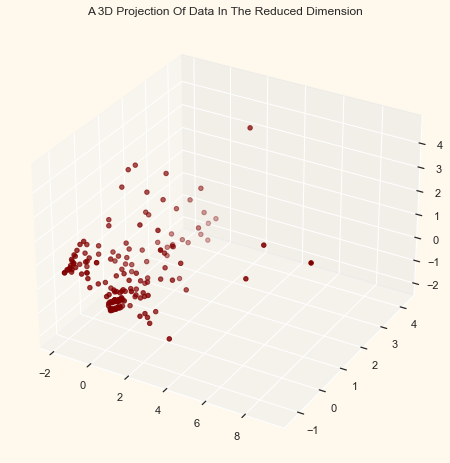

In [22]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_df_copy["col1"]
y =PCA_df_copy["col2"]
z =PCA_df_copy["col3"]
#Plotear
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

## CLUSTERING


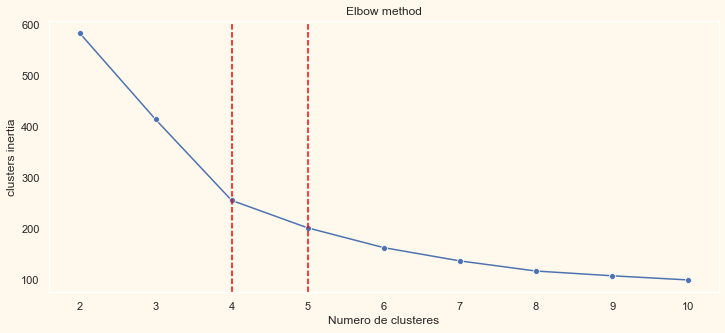

In [23]:
# Uso de Elbow method para determinar el numero de cluster

n_clusters = [2,3,4,5,6,7,8,9,10] # numero de clusters
clusters_inertia = [] # inertia de clusters
s_scores = [] # puntuacion silueta

for n in n_clusters:
    KM_est = KMeans(n_clusters=n, init='k-means++').fit(PCA_df_copy)
    clusters_inertia.append(KM_est.inertia_)    # data para el elbow method
    silhouette_avg = silhouette_score(PCA_df_copy, KM_est.labels_)
    s_scores.append(silhouette_avg) # data para el silhouette score method
    
#Se plotea el codo
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(n_clusters, clusters_inertia, marker='o', ax=ax)
ax.set_title("Elbow method")
ax.set_xlabel("Numero de clusteres")
ax.set_ylabel("clusters inertia")
ax.axvline(4, ls="--", c="red")#marcar en rojo el posible parametro para k (en la curva)
ax.axvline(5, ls="--", c="red")#marcar en rojo el posible parametro para k (en la curva)
plt.grid()
plt.show()

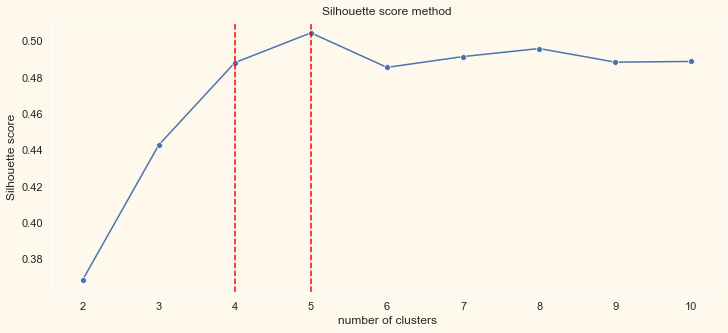

In [24]:
#Se plotea la silueta

fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(n_clusters, s_scores, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(4, ls="--", c="red")
ax.axvline(5, ls="--", c="red")
plt.grid()
plt.show()

### K-MEANS 

In [25]:
#Importar modulo Kmeans
from sklearn.cluster import KMeans


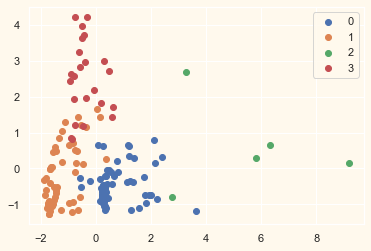

In [26]:
# 4 CLUSTERES

pca = PCA(3)
 
#Transform the data
df = pca.fit_transform(scaled_df_copy)
  
KM_4_clusters = KMeans(n_clusters=4, init='k-means++')

label = KM_4_clusters.fit_predict(PCA_df_copy) # inicializar y ajustar el modelo K-Means


#Añadiendo la columna de los clusters al df original
usuarios_kmeans4 = usuarios_clustering.copy()
usuarios_kmeans4["Cluster"]= label


#Getting unique labels
u_labels4 = np.unique(label)

# Getting the cluster centers
C4 = KM_4_clusters.cluster_centers_
 
#plotting the results:
for i in u_labels4:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

In [27]:
#Obtener numero de instancias para cada cluster
KM_clust_sizes = usuarios_kmeans4.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
Cluster,
0,87
1,56
2,5
3,23


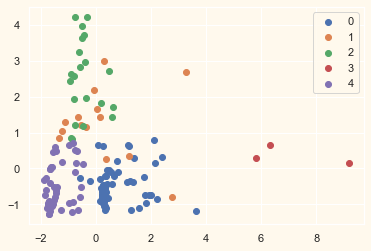

In [28]:
#5 CLUSTERES

pca = PCA(3)
 
#Transform the data
df = pca.fit_transform(scaled_df_copy)
 
#Import KMeans module
from sklearn.cluster import KMeans
 
KM_5_clusters = KMeans(n_clusters=5, init='k-means++')

label = KM_5_clusters.fit_predict(PCA_df_copy) # inicializar y ajustar el modelo K-Means

#Añadiendo la columna de los clusters al df original
usuarios_kmeans5 = usuarios_clustering.copy()
usuarios_kmeans5["Cluster"]= label

 
#Getting unique labels
u_labels5 = np.unique(label)

# Getting the cluster centers
C5 = KM_5_clusters.cluster_centers_

#plotting the results:
for i in u_labels5:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

In [29]:
### Obtener numero de instancias para cada cluster
KM_clust_sizes = usuarios_kmeans5.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
Cluster,
0,85
1,14
2,21
3,3
4,48


In [30]:
##Juntar en el dataframe de los kmeans 4 y 5 los usuarios respectivos
kmeans4_clustering = pd.concat([user_mdl_id, usuarios_kmeans4], axis=1)#se añaden las dos columnas (usuario y mdl_user_id)
kmeans5_clustering = pd.concat([user_mdl_id, usuarios_kmeans5], axis=1)#se añaden las dos columnas (usuario y mdl_user_id)


### AGLOMERATIVE CLUSTERING 

In [31]:
PCA_df_copy

,col1,col2,col3
0,0.747729,0.219569,-0.457563
1,1.574454,-1.100832,0.476735
2,1.255193,-1.153843,0.047894
3,0.309723,-1.041679,-0.020778
4,0.283042,-0.787641,-0.126540
...,...,...,...
166,0.229617,-0.762173,-0.497896
167,0.321778,-0.683981,-0.588883
168,2.410179,0.317311,0.663214
169,0.070746,0.641402,-1.032942


In [32]:
#Iniciando el modelo Aglomerative clustering
AC = AgglomerativeClustering(n_clusters=4)
# fit el modelo y predecir los clusteres
yhat_AC = AC.fit_predict(PCA_df_copy)
PCA_df_copy["Clusters"] = yhat_AC
#Añadiendo la columna de los clusters al df original
usuarios_clustering["Clusters"]= yhat_AC

In [33]:
yhat_AC

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 3, 1, 2, 2, 2, 2, 1, 2,
       2, 2, 1, 1, 0, 1, 2, 2, 2, 2, 0, 3, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 3, 0, 0, 2, 1, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 2, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 2, 0, 1, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

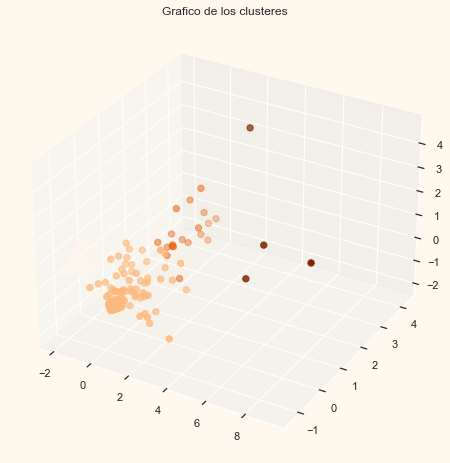

In [34]:
#Para examinar los grupos formados echemos un vistazo a la distribución 3D de los grupos.

#Ploteando clusteres
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=usuarios_clustering["Clusters"], marker='o', cmap = 'Oranges' )
ax.set_title("Grafico de los clusteres")
plt.show()

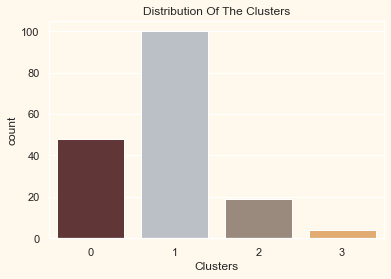

,KM_size
Clusters,
0,48
1,100
2,19
3,4


In [35]:
#En primer lugar, echemos un vistazo a la distribución grupal de clustring

#Plotear distribucion cluster
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=usuarios_clustering["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

#Mirar los usuarios en cada cluster
aglomerative_sizes = usuarios_clustering.groupby('Clusters').size().to_frame()
aglomerative_sizes.columns = ["KM_size"]
aglomerative_sizes

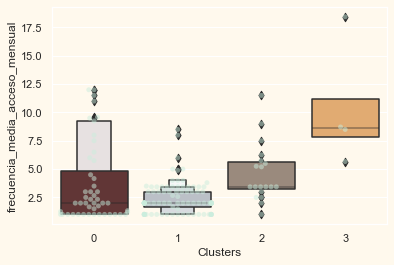

In [36]:
#Comparacion clusteres en cuanto a la media de acceso por usuario

plt.figure()
pl=sns.swarmplot(x=usuarios_clustering["Clusters"], y=usuarios_clustering["frecuencia_media_acceso_mensual"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=usuarios_clustering["Clusters"], y=usuarios_clustering["frecuencia_media_acceso_mensual"], palette=pal)
plt.show()

In [37]:
usuarios_clustering

,nota_media_curso,num_cursos,num_actividades,nota_media_actividades,num_programas,frecuencia_media_acceso_mensual,Clusters
0,0.666667,15.0,3,10.000000,3,1.000000,1
1,4.091000,10.0,46,7.882088,3,3.435001,1
2,2.222222,9.0,44,8.575606,2,3.435001,1
3,3.858000,5.0,44,8.031091,1,3.435001,1
4,2.914000,5.0,39,8.286821,1,3.435001,1
...,...,...,...,...,...,...,...
168,2.754444,18.0,18,9.916000,1,2.000000,1
169,3.065000,18.0,22,9.195000,1,2.000000,1
170,1.283333,36.0,19,9.240000,2,8.000000,1
171,0.509444,18.0,3,9.170000,1,2.000000,1


In [38]:
mean_aglo_clustering = usuarios_clustering.groupby('Clusters').mean()#media de caracteristicas por cluster
mean_aglo_clustering

,nota_media_curso,num_cursos,num_actividades,nota_media_actividades,num_programas,frecuencia_media_acceso_mensual
Clusters,,,,,,
0,8.282014,5.687500,12.187500,9.394460,1.166667,3.630903
1,2.767549,17.290000,19.770000,9.159720,1.340000,2.378787
2,1.641542,9.210526,3.368421,5.378818,1.157895,4.608421
3,0.634206,47.000000,22.500000,8.514322,7.750000,10.331349


In [39]:
aglo_clustering = pd.concat([user_mdl_id, usuarios_clustering], axis=1)#se añaden las dos columnas (usuario y mdl_user_id)
aglo_clustering.head()

,user_id,mdl_user_id,nota_media_curso,num_cursos,num_actividades,nota_media_actividades,num_programas,frecuencia_media_acceso_mensual,Clusters
0,3.0,13.0,0.666667,15.0,3.0,10.000000,3.0,1.000000,1.0
1,4.0,14.0,4.091000,10.0,46.0,7.882088,3.0,3.435001,1.0
2,5.0,15.0,2.222222,9.0,44.0,8.575606,2.0,3.435001,1.0
3,7.0,18.0,3.858000,5.0,44.0,8.031091,1.0,3.435001,1.0
4,8.0,19.0,2.914000,5.0,39.0,8.286821,1.0,3.435001,1.0


### EVALUANDO ALGORITMOS  

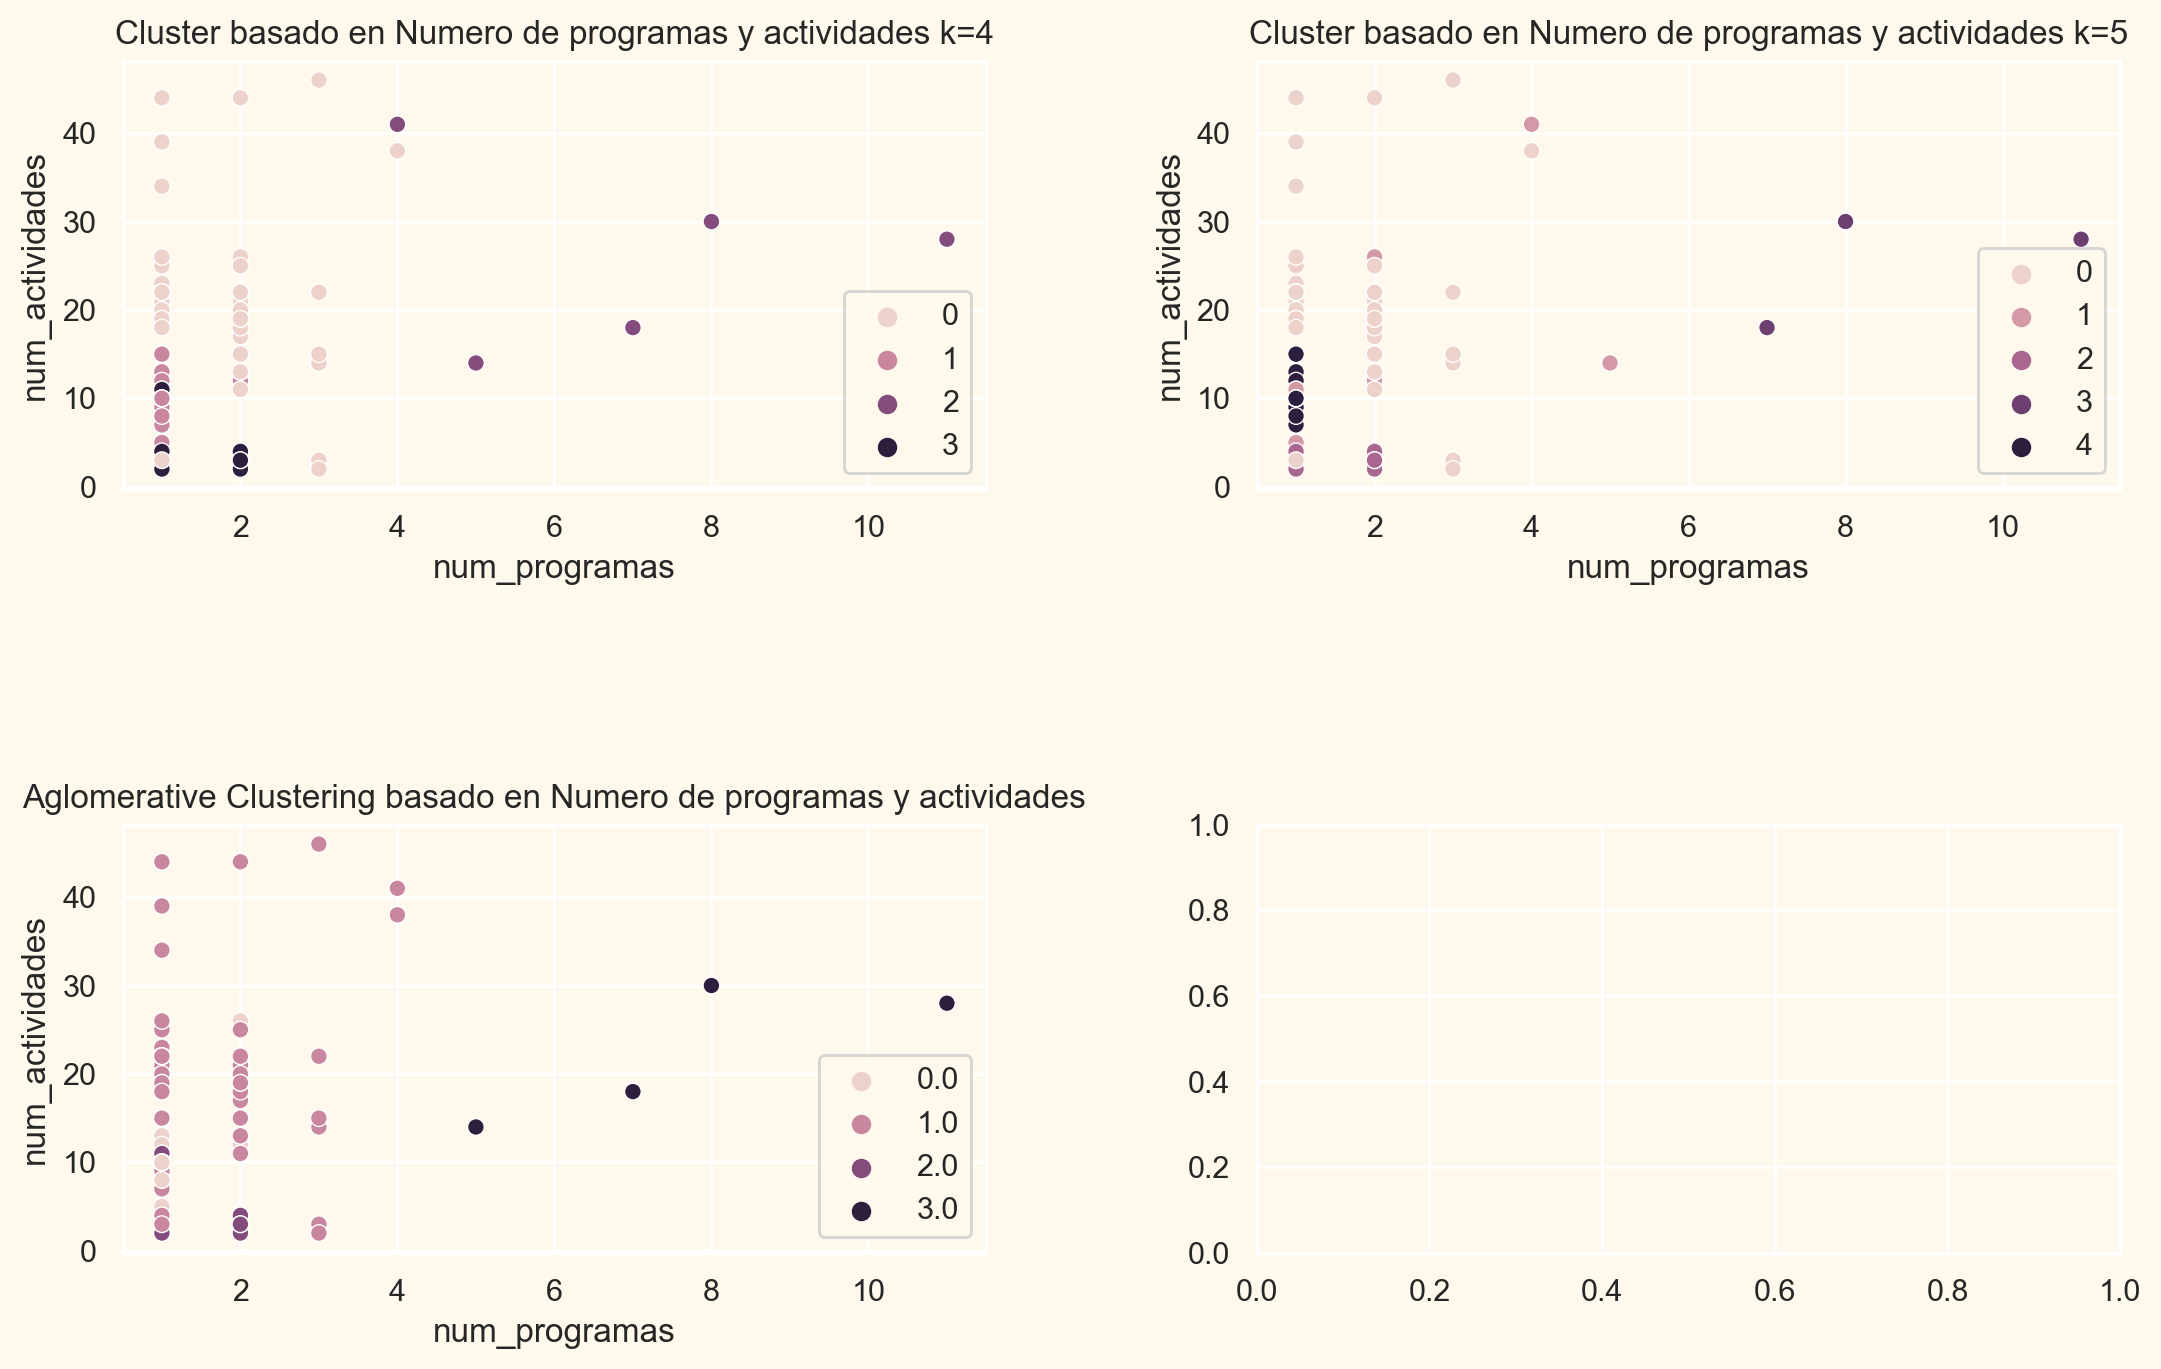

In [40]:
#En primer lugar, echemos un vistazo a la distribución grupal de clustering

fig1, ax1 = plt.subplots(2,2)

sns.scatterplot(ax = ax1[0,0], data = usuarios_kmeans4,x=usuarios_kmeans4["num_programas"], y=usuarios_kmeans4["num_actividades"],hue=usuarios_kmeans4["Cluster"])
sns.scatterplot(ax = ax1[0,1], data = usuarios_kmeans5,x=usuarios_kmeans5["num_programas"], y=usuarios_kmeans5["num_actividades"],hue=usuarios_kmeans5["Cluster"])
sns.scatterplot(ax = ax1[1,0], data = aglo_clustering,x=aglo_clustering["num_programas"], y=aglo_clustering["num_actividades"],hue=aglo_clustering["Clusters"])

ax1[0,0].set_title("Cluster basado en Numero de programas y actividades k=4")
ax1[0,1].set_title("Cluster basado en Numero de programas y actividades k=5")
ax1[1,0].set_title("Aglomerative Clustering basado en Numero de programas y actividades")


ax1[0,0].legend()
ax1[0,1].legend()
ax1[1,0].legend()

fig1.show()
fig1.tight_layout()
fig1.set_size_inches(12,8)
fig1.set_dpi(200)

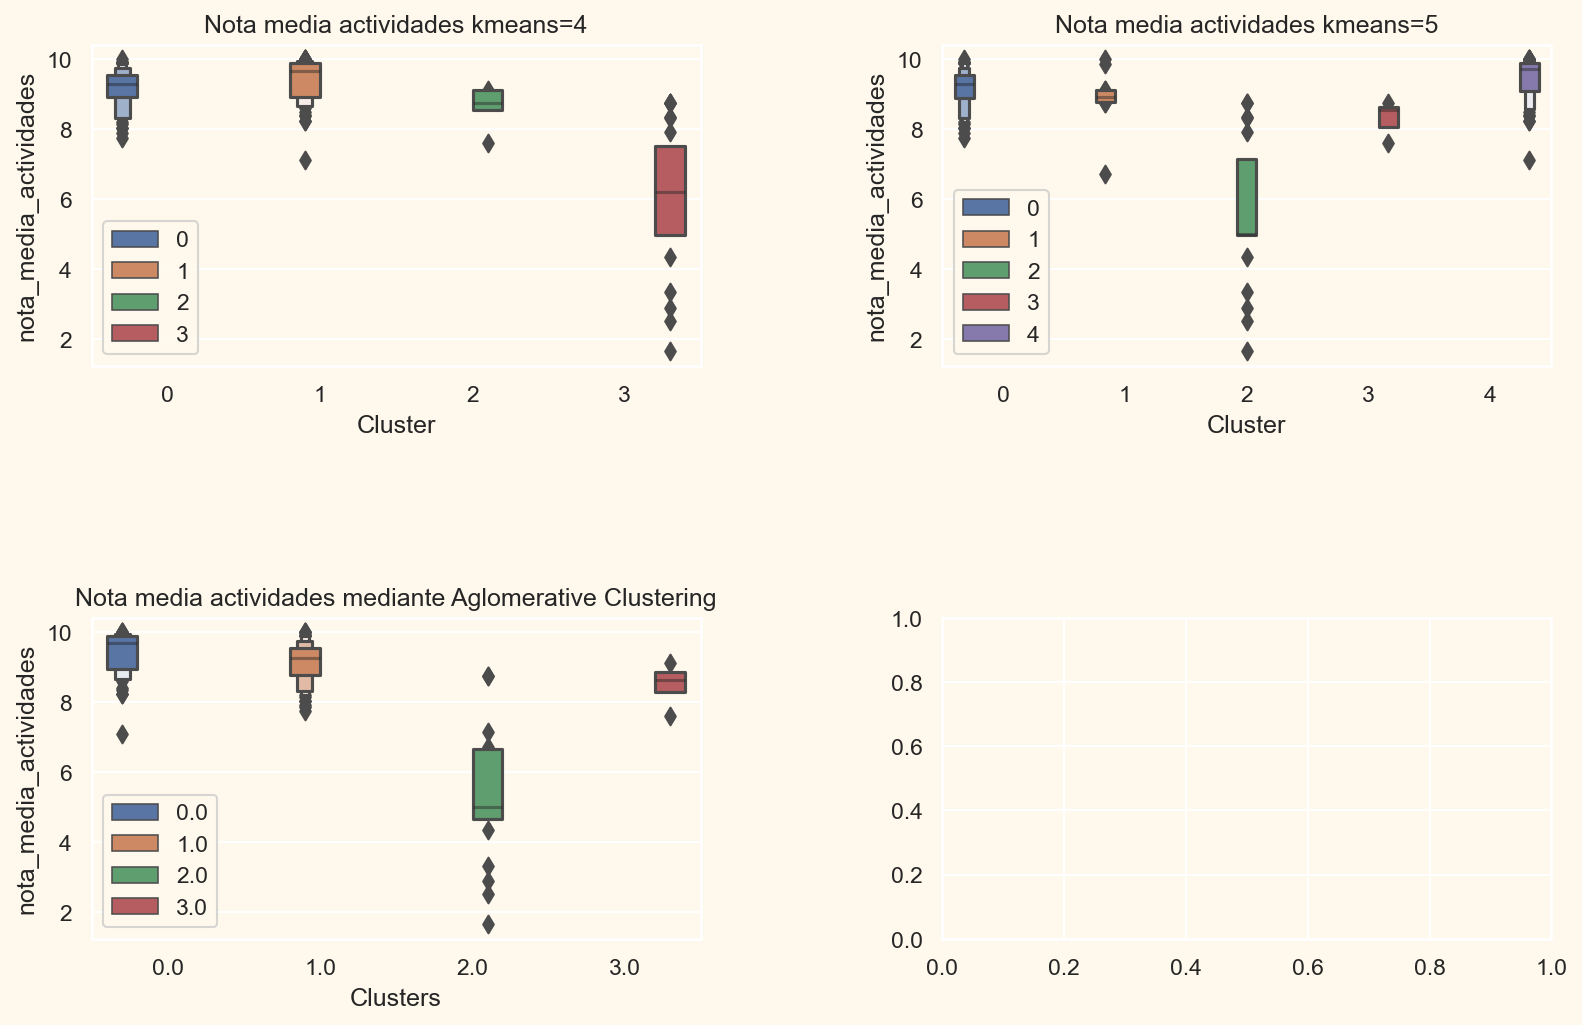

In [41]:
fig2, ax2 = plt.subplots(2,2)

sns.boxenplot(ax = ax2[0,0], data = usuarios_kmeans4,x=usuarios_kmeans4["Cluster"], y=usuarios_kmeans4["nota_media_actividades"],hue=usuarios_kmeans4["Cluster"])
sns.boxenplot(ax = ax2[0,1], data = usuarios_kmeans5,x=usuarios_kmeans5["Cluster"], y=usuarios_kmeans5["nota_media_actividades"],hue=usuarios_kmeans5["Cluster"])
sns.boxenplot(ax = ax2[1,0], data = aglo_clustering,x=aglo_clustering["Clusters"], y=aglo_clustering["nota_media_actividades"],hue=aglo_clustering["Clusters"])

ax2[0,0].set_title("Nota media actividades kmeans=4")
ax2[0,1].set_title("Nota media actividades kmeans=5")
ax2[1,0].set_title("Nota media actividades mediante Aglomerative Clustering")


ax2[0,0].legend()
ax2[0,1].legend()
ax2[1,0].legend()

fig2.show()
fig2.tight_layout()
fig2.set_size_inches(12,8)
fig2.set_dpi(150)

### CONCLUSION 

## CONVERTIR EN PY

In [42]:
!jupyter nbconvert --to script Clustering.ipynb

[NbConvertApp] Converting notebook Clustering.ipynb to script
[NbConvertApp] Writing 24336 bytes to Clustering.py
